In [1]:
import os
import json
import time
import gzip
import bcolz
import numpy as np
import re
import copy
from multiprocessing import Pool
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

try:
    import cPickle as pickle
except:
    import pickle

## Loading the Dataset

In [2]:
pickleFile = '../Datasets/Reviews/dataset.pkl'
start = time.clock()
dataset = pickle.load( open( pickleFile, "rb" ))
duration = time.clock() - start
print("Loaded the dataset in", round(duration,2), "seconds.")

Loaded the dataset in 7.0 seconds.


In [3]:
print("There are",len(dataset), "amazon items.")

There are 63001 amazon items.


## Loading Glove Words

In [4]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")


gloveDimension = 50
glovePath = "/media/data/Datasets/glove"
glove = loadGlove(glovePath, dim=gloveDimension)
gloveWords = glove.keys()

Preloading files.. Done.


In [5]:
print("Glove Vocabulary Size:",len(gloveWords))

Glove Vocabulary Size: 400000


## Preprocessing Data

In [6]:
def preprocess(paragraph):
    # split paragraph by full stops
    paragraph = paragraph.lower()
    paragraph = re.sub("([,!?()-+&£$.%*'])", r' \1 ', paragraph)
    paragraph = re.sub('\s{2,}', ' ', paragraph)
    paragraph = paragraph.split(" ")
    # remove empty string
    return paragraph

def padSentence(words, maxLength, eosString="<eos>", padString="<pad>"):
    words = words[:maxLength-1] + [eosString]
    return words + [padString for i in range(maxLength - len(words))]
    
def discretise(value, word):
    return word + "_" + str(value)

In [7]:
def handleItem(itemID, dataset=dataset):
    """
    Filters words out based on whether they're in the GloVe dataset or not.
    
    Parameters:
    
    """
    count = 0
    legit = 0
    printDebug = False

    reviews = []
    for i in range(len(dataset[itemID])):
        # initialise variables
        entry = dataset[itemID][i]
        reviewerID = entry['reviewerID']

        """
        Review Text Processing
        """
        # preprocess review

        # split sentences
        sentences = re.split(r'(?<=\.) ', entry['reviewText'])
        for s in range(len(sentences)):
            sentence = sentences[s]
            sentences[s] = list(filter(None, preprocess(sentence)))

#             words = preprocess(entry['reviewText'])
#             words = [w for w in words if w in wordbase]
#             words = words[:maxReviewLength]

        # preprocess summary
        summary = preprocess(entry['summary'])

        # start of sequence
        # start of review
        # end of review
        entries =  [["<sos>"]] + [summary] + [["<sor>"]] + sentences + [["<eos>"]]

        # setup review parameters
        rating   = [discretise(entry['overall'], "rating")]

        # process polarity
        good, bad = entry['helpful'][0], entry['helpful'][1]
        try:
            polarity = (good - bad) / (good + bad)
        except ZeroDivisionError:
            polarity = 0
        polarity = np.tanh(polarity)
        polarity = np.round(polarity, 1)
        polarity = [discretise(polarity, "polarity")]

        # create identity/conditioning entry
        identifier = itemID.lower()
        identity = [l for l in identifier] + rating + polarity

        # add conditionining entry to each entry
        formatted = [identity + entry for entry in entries]


        if printDebug:
            print(dataset[itemID][i])
            print(identity)
            print(entries)
            print()
#                 print("----------")
            print(formatted)
            print()
            print("--------------")

        for i in range(len(formatted)-1):
            reviews.append([formatted[i], formatted[i+1]])
    
    return reviews

In [8]:
datasetKeys = list(dataset.keys())

In [9]:
print(len(datasetKeys))

63001


In [10]:
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [11]:
reviews = processItems(handleItem,datasetKeys[::16])

100%|██████████| 3938/3938 [00:06<00:00, 644.20it/s]


In [12]:
datasetSize = len(reviews)
trainPortion = 0.8
valPortion = 0.2

trainRatio = int(datasetSize * trainPortion)
valRatio = int(datasetSize * valPortion)

train = reviews[:trainRatio]
validation = reviews[trainRatio:]

print(len(train), len(validation))

# now we need to flatten train and validation.
trainents = []
for review in train:
    trainents += [entry for entry in review]
valents = []
for review in validation:
    valents += [entry for entry in review]
    
train = trainents
validation = valents

print(len(train), len(validation))

3150 788
751694 179357


## Getting ID's of words

To improve the throughput of the model, we should reduce the embedding size. Here we'll look at all the words and keep track ones that exist. We'll make a reduced word2id based on this set.

In [13]:
wordcounts = {}

In [14]:
# here we reduce the size of the dataset so we can debug our model.
print("Subsetting Reviews..")
print("We now have", len(train), "reviews.")

Subsetting Reviews..
We now have 751694 reviews.


In [15]:
# get word frequency for words in training data
for row in tqdm(train):
    for sequences in row:
        for word in sequences:
            word = str(word)
            if word not in wordcounts:
                wordcounts[word] = 0
            wordcounts[word] += 1

100%|██████████| 751694/751694 [00:12<00:00, 58307.65it/s]


In [16]:
# get words that are not in the glove dataset
knowns   = [word for word in wordcounts if word in glove]
unknowns = [word for word in wordcounts if word not in glove]
# sort words by their frequency
wordOrder = list(sorted(knowns, key=lambda x: wordcounts[x], reverse=True))

In [17]:
print(len(knowns), len(unknowns))

43017 96094


In [18]:
vocabularyLimit = 30000

In [19]:
wordOrder = wordOrder[:vocabularyLimit]

In [20]:
weights = [glove[word] for word in wordOrder]

In [21]:
for word in unknowns:
    if ("rating" in word) or ("polarity" in word):
        try:
            part = word.split("_")
            if part[1] == "-0.0":
                part[1] = "0.0"
            weight = glove[part[0]] + glove[part[1]]
            wordOrder.append(word)
            weights.append(weight)
        except:
            pass

In [22]:
# create dictionaries for constant time referencing
id2word = {idx: w for (idx, w) in enumerate(wordOrder)}
word2id = {w: idx for (idx, w) in enumerate(wordOrder)}

In [23]:
lim = len(word2id)
# add <eos>
weights.append(glove['eos'])
word2id['<eos>'] = lim
id2word[lim] = '<eos>'
lim += 1
# add <sos>
weights.append(glove['sos'])
word2id['<sos>'] = lim
id2word[lim] = ['<sos>']
lim += 1

# add <sor> (start of review)
sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<sor>'] = lim
id2word[lim] = '<sor>'
lim += 1

weights.append(glove['unk'])
word2id['<unk>'] = lim
id2word[lim] = '<unk>'

In [24]:
def wordToID(word,corp=word2id):
    if word in corp:
        return corp[word]
    return corp['<unk>']

def IDToWord(id,corp=id2word, ref=word2id):
    if word in corp:
        return corp[word]
    return corp[ref['<unk>']]

In [25]:
# convert words to their id's in the review.
def entriesToWordIDs(group):
    return [[[wordToID(word) for word in seq] for seq in row] for row in tqdm(group)]
    
train = entriesToWordIDs(train)
validation = entriesToWordIDs(validation)

100%|██████████| 179357/179357 [00:01<00:00, 108398.33it/s]


In [26]:
sizes = {}
for row in tqdm(train):
    for seq in row:
        length = len(seq)
        if length not in sizes:
            sizes[length] = 0
        sizes[length] += 1

seqlengths = list(sorted(sizes.keys(), key=lambda x: sizes[x], reverse=True))
max(seqlengths)

100%|██████████| 751694/751694 [00:00<00:00, 1389472.74it/s]


1708

In [27]:
for i in range(1709):
    if i not in sizes:
        sizes[i] = 0

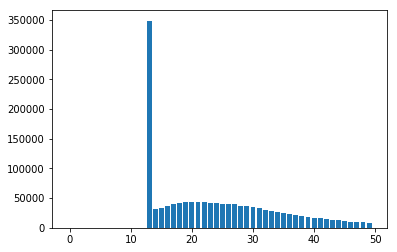

In [28]:
ents = [x for x in range(0,50)]
bins = [sizes[x] for x in ents]
plt.bar(ents,bins)
plt.show()

In [29]:
cutoff = seqlengths[37]
print("Cutoff sequence length:", cutoff)

Cutoff sequence length: 50


In [30]:
def trimSeq(group):
    return [[seq[:cutoff] for seq in row] for row in tqdm(group)]

train = trimSeq(train)
validation = trimSeq(validation)

100%|██████████| 179357/179357 [00:00<00:00, 713219.73it/s]


In [31]:
# create container ready for use in dataset
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'weights' : np.matrix(weights)
}

In [32]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

In [33]:
datasetFile = '../Datasets/Reviews/dataset_ready.pkl'
# save the dataset to a pickle file.
output = open(datasetFile, 'wb')
pickle.dump(container, output)
output.close()
print("Saved!", convert_bytes(os.stat(datasetFile).st_size))

Saved! 138.7 MB
